# Régressions linéaires par méthode des moindre carré

Il existe plusieurs moyens simples de faire une régression linéaire sous Python :
* la fonction `np.polyfit` qui a l'avantage de pouvoir faire également une régression polynomiale mais qui ne retourne pas  ou peu d'information sur les incertitudes ou la corrélation dans son utilisation la plus simple
* la fonction `scipy.stats.linregress` qui retourne les incertitudes sur les paramètres mais ne permet pas de pondérer les points
* les fonction `scipy.optimize.least_squares` et `scipy.optimize.curve_fit` qui marchent également pour des régression non linéaires.

Pour rappel (ou information), les coefficients déterminés ne sont pas indépendants et ne peuvent donc pas être considérés comme décorrélés pour traiter les incertitudes.

## Incertitude inconnue ou supposée constante pour tous les points

a: 6.7541e+01 b:5.2859e+00
Matrice de covariance
[[ 0.59587452 -2.97937259]
 [-2.97937259 20.85560812]]
a : 67.54072722331425 u_a 0.7719290884500211
b : 5.285888431105874 u_b 4.566794074165684


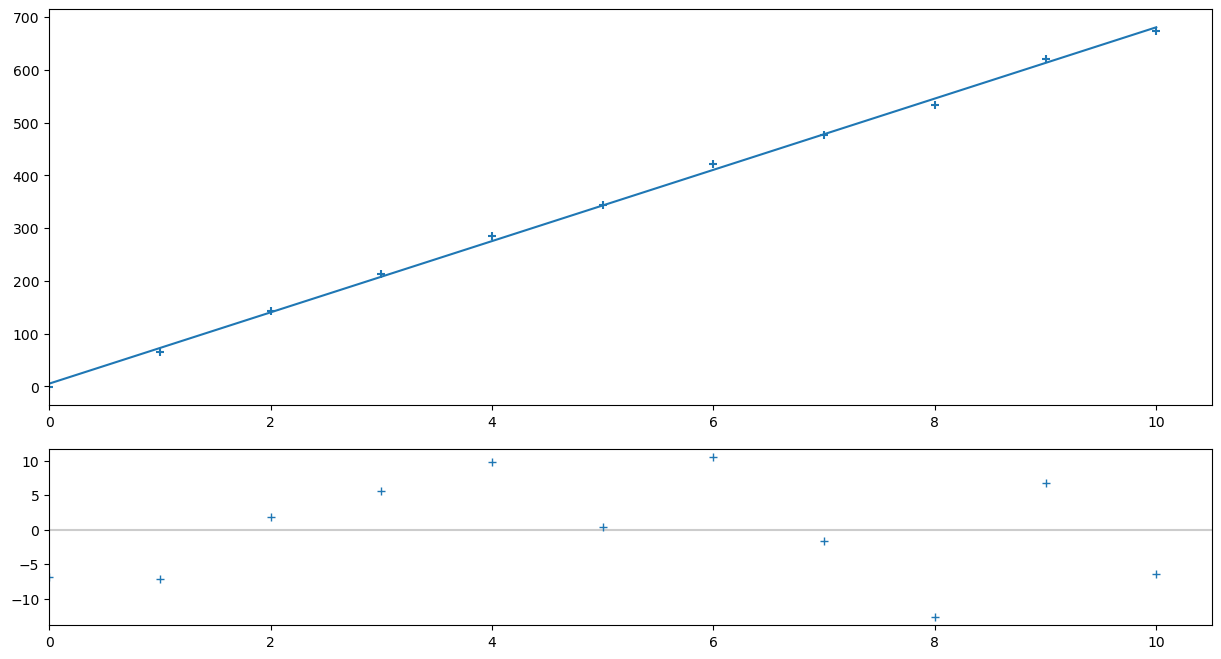

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import scipy
import scipy.stats as stats
import numpy as np
import packaging

if __name__ == "__main__":
    # Création de points
    sampling = 11
    rng = np.random.default_rng()
    us = rng.normal(loc=0, scale=10, size=sampling)
    a, b = rng.uniform(0, 100, size=2)
    xs = np.linspace(0, 10, sampling)
    ys = a * xs + us

    # tracé des points correspondants
    fig = plt.figure(figsize=(15, 8))
    gs = fig.add_gridspec(3, 1, hspace=0.25)
    ax1 = fig.add_subplot(gs[0:2, 0])
    # points bruts
    ax1.scatter(xs, ys, marker="+")

    # Utilisation de polyfit et polyval pour faire la régression linéaire
    coeffs, cov = np.polyfit(xs, ys, deg=1, cov=True)
    a_mod, b_mod = coeffs
    y_mod = np.polyval(coeffs, xs)
    print("a: {:.4e} b:{:.4e}".format(a_mod, b_mod))
    print("Matrice de covariance")
    print(cov)
    print(
        "a : {} u_a {}\nb : {} u_b {}".format(
            a_mod, np.sqrt(cov[0, 0]), b_mod, np.sqrt(cov[1, 1])
        )
    )

    """
    ##Code équivalent avec des informations légèrement différentes
    #régression linéaire avec linregress
    res = stats.linregress(xs, ys)
    a_linregress,b_linregress,r,p,ua=res


    #on affiche l'incertitude sur l'ordonnée à l'origine uniquement pour les versions pas trop vieilles de scipy
    if packaging.version.parse(scipy. __version__) > packaging.version.parse('1.6') :
        #il manque l'incertitude sur l'ordonnée à l'origine pour les versions de scipy inférieures à 1.6
        ub=res.intercept_stderr
        print('a : {} u_a {}\nb : {} u_b {}'.format(a_linregress,ua,b_linregress,ub))
        print('r² : {}'.format(r**2))
    else:
        print('a : {} u_a {}\nb : {} '.format(a_linregress,ua,b_linregress))
    """

    # tracé de la modélisation
    ax1.plot(xs, y_mod)

    ax2 = fig.add_subplot(gs[2, 0])
    ax2.hlines(0, 0, 20, color="#cccccc")

    # tracé des résidus
    residus = ys - y_mod
    ax2.plot(xs, residus, marker="+", ls="")
    ax1.set_xlim(1.05 * np.min(xs), 1.05 * np.max(xs))
    ax2.set_xlim(1.05 * np.min(xs), 1.05 * np.max(xs))
    plt.show()

## Incertitude connue sur les valeurs mesurées

Lorsque les incertitudes sont connues, il faut pondérer les points par l'inverse de l'incertitude. Ici, on prend une décroissance exponentielle avec une incertitude constante sur la mesure directe. L'opération de linéarisation fait que les incertitudes ne sont plus constantes sur la grandeur linéarisée. 

Il faut alors donner des poids aux points pour la régression linéaire pour que celle-ci soit correcte.

a: -4.9017e-01 b:2.2962e+00
Matrice de covariance
[[ 2.19102065e-05 -1.87066081e-05]
 [-1.87066081e-05  3.85001855e-05]]
a : -0.49017196802927665 u_a 0.004680833957021175
b : 2.2962236675404064 u_b 0.006204851769833942


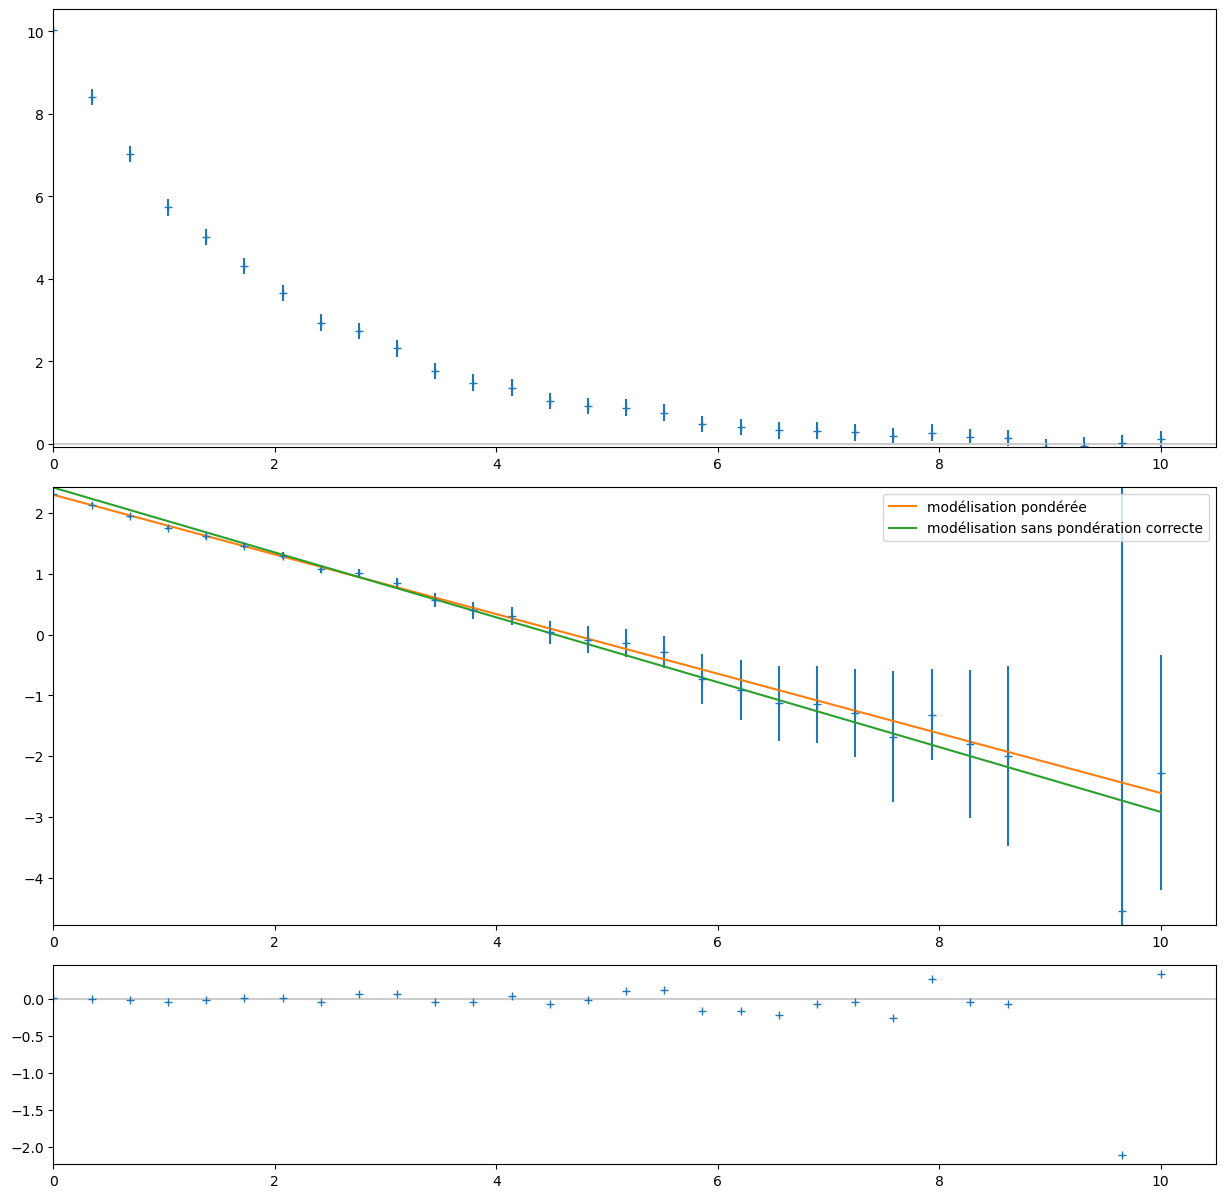

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import scipy
import scipy.stats as stats
import numpy as np
import packaging


if __name__ == "__main__":
    # Création de points
    sampling = 30
    rng = np.random.default_rng(25)
    u_z = 0.1
    us = rng.normal(loc=0, scale=u_z, size=sampling)
    xs = np.linspace(0, 10, sampling)
    base = 10 * np.exp(-0.5 * xs)
    zs = base + us

    # tracé des points correspondants
    fig = plt.figure(figsize=(15, 15))
    gs = fig.add_gridspec(5, 1)
    ax1 = fig.add_subplot(gs[0:2, 0])
    # points bruts
    ax1.errorbar(xs, zs, yerr=2 * u_z, ls="", marker="+")
    ax1.hlines(0, 0, 20, color="#cccccc")
    ax1.set_ylim(1.05 * np.min(zs), 1.05 * np.max(zs))
    ax1.set_xlim(1.05 * np.min(xs), 1.05 * np.max(xs))

    # Linéarisation des points
    ax2 = fig.add_subplot(gs[2:4, 0])
    ys = np.log(zs[zs > 0])
    # calcul de l'incertitude par propagation suite à la linéarisation
    # y = f(z) -> u_y = df/dz * u_z
    uys = 1 / zs[zs > 0] * 0.1
    ax2.errorbar(xs[zs > 0], ys, yerr=2 * uys, ls="", marker="+")
    # Utilisation de polyfit et polyval pour faire la régression linéaire pondérée
    coeffs, cov = np.polyfit(xs[zs > 0], ys, deg=1, cov=True, w=1 / uys)
    a_mod, b_mod = coeffs
    y_mod = np.polyval(coeffs, xs[zs > 0])
    print("a: {:.4e} b:{:.4e}".format(a_mod, b_mod))
    print("Matrice de covariance")
    print(cov)
    print(
        "a : {} u_a {}\nb : {} u_b {}".format(
            a_mod, np.sqrt(cov[0, 0]), b_mod, np.sqrt(cov[1, 1])
        )
    )
    # tracé de la modélisation
    ax2.plot(xs[zs > 0], y_mod, label="modélisation pondérée")

    ax2.plot(
        xs[zs > 0],
        np.polyval(np.polyfit(xs[zs > 0], ys, deg=1), xs[zs > 0]),
        label="modélisation sans pondération correcte",
    )
    ax2.legend()
    ax2.set_ylim(1.05 * np.min(ys), 1.05 * np.max(ys))

    ax3 = fig.add_subplot(gs[4, 0])
    ax3.hlines(0, 0, 20, color="#cccccc")

    # tracé des résidus
    residus = ys - y_mod
    ax3.plot(xs[zs > 0], residus, marker="+", ls="")

    ax2.set_xlim(1.05 * np.min(xs), 1.05 * np.max(xs))
    ax3.set_xlim(1.05 * np.min(xs), 1.05 * np.max(xs))
    plt.show()

## Optimisation non linéaire avec `curve_fit`

On va ici faire une optimisation directe via `curve_fit` sur la courbe non linéarisée. 

https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html#scipy.optimize.curve_fit
Dans ce cas, il faut **systématiquement** essayer de donner un bon jeu de paramètres initiaux pour éviter de tomber dans un minimum relatif, ici, même au doig mouillé, on voit que l'amplitude est vers 10 et que la constante de temps est proche de 0,5.

[9.95050487 0.49299287]
[0.06879859 0.00524263]


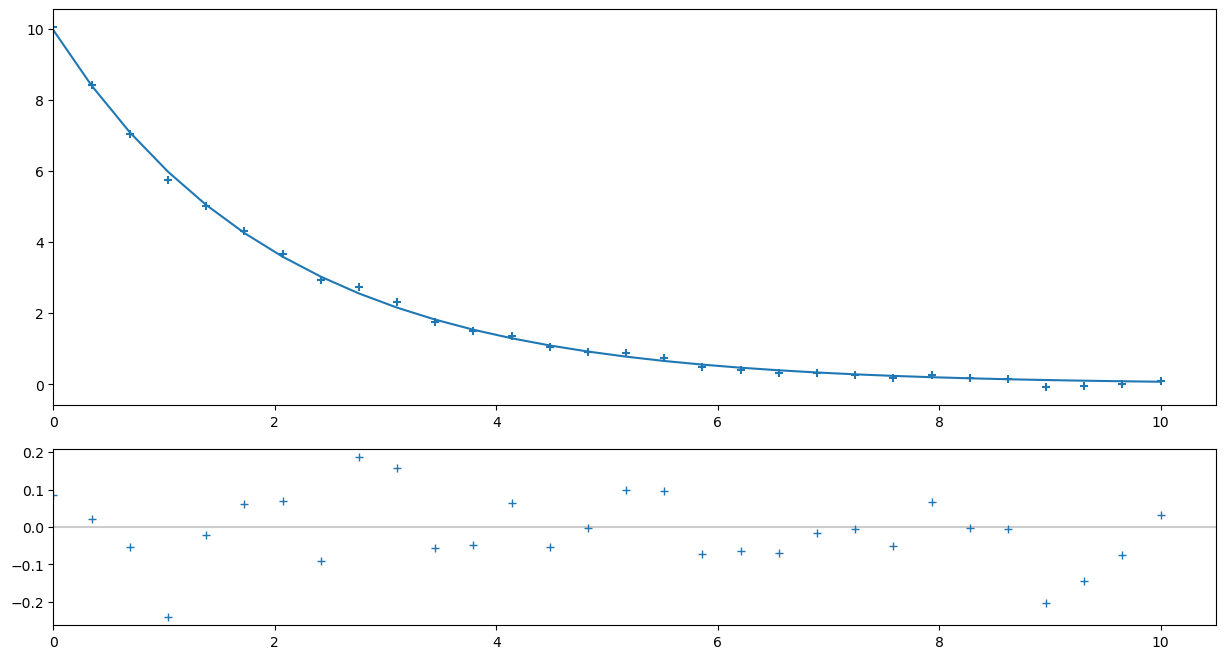

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import scipy
import scipy.stats as stats
import scipy.optimize as optimize
import numpy as np


def func_exp(x, amp, k):
    # la variable x doit forcément être le premier argument de la fonction,
    # les paramètres sont placés après
    return amp * np.exp(-k * x)


if __name__ == "__main__":
    # Création de points
    sampling = 30
    rng = np.random.default_rng(25)
    u_z = 0.1
    us = rng.normal(loc=0, scale=u_z, size=sampling)
    xs = np.linspace(0, 10, sampling)
    base = 10 * np.exp(-0.5 * xs)
    ys = base + us

    # tracé des points correspondants
    fig = plt.figure(figsize=(15, 8))
    gs = fig.add_gridspec(3, 1, hspace=0.25)
    ax1 = fig.add_subplot(gs[0:2, 0])
    # points bruts
    ax1.scatter(xs, ys, marker="+")

    # Utilisation de polyfit et polyval pour faire la régression linéaire
    # On donne des paramètres initiaux pour faciliter la convergence de l'optimisation.
    res = optimize.curve_fit(func_exp, xs, ys, p0=[10, 0.5])
    # paramètres optimaux
    popt = res[0]
    cov = res[1]
    # paramètres optimaux dans l'ordre de la définition de la fonction
    print(popt)
    # estimation de l'incertitude sur les paramètres
    print(np.sqrt(np.diag(cov)))
    y_mod = func_exp(xs, *popt)

    # tracé de la modélisation
    ax1.plot(xs, y_mod)

    ax2 = fig.add_subplot(gs[2, 0])
    ax2.hlines(0, 0, 20, color="#cccccc")

    # tracé des résidus
    residus = ys - y_mod
    ax2.plot(xs, residus, marker="+", ls="")
    ax1.set_xlim(1.05 * np.min(xs), 1.05 * np.max(xs))
    ax2.set_xlim(1.05 * np.min(xs), 1.05 * np.max(xs))
    plt.show()

## Optimisation non linéaire avec least-squares

Pour least_squares https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html#scipy.optimize.least_squares

La philosophie est totalement différente, il faut :
1. définir la fonction modèle `func_mod`  avec **un unique vecteur qui va contenir tous les paramètrs à optimiser en tant que premier argument** 
2. définir une fonction qu'on cherche à minimiser par méthode des moindres carré donc en général : `ys-func_mod(p,xs)` où les `ys` sont les grandeurs observées et `func_mod(p,xs)` correspond aux points modélisés.
3. appeler la fonction least_squares en fournissant **obligatoirement** des paramètres initiaux et ici, en passant les arguments de la fonction `func_mod`  via le mot clé `args` pour fournir les valeur des x et y sur lesquels faire la régression non linéaire.

[9.95050487 0.49299287]


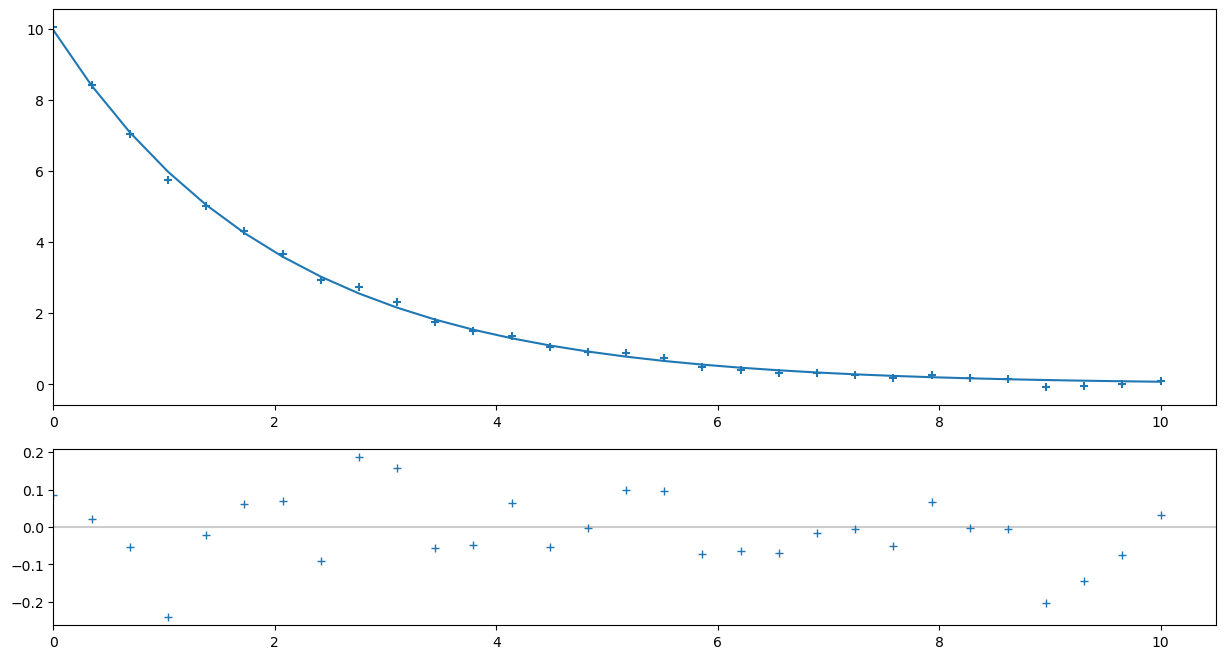

In [4]:
import matplotlib
import matplotlib.pyplot as plt
import scipy
import scipy.stats as stats
import scipy.optimize as optimize
import numpy as np


def func_exp(p, xs):
    # ici, à l'inverse de précédemment, les paramètres doivent être en premier
    # et la variable en deuxième. Les paramètres sont stockés sous forme de vecteur
    """
    p : ensemble des paramètres à trouver sous forme de vecteur
    p[0] : amplitude de l'exponentielle
    p[1] : constante de temps

    xs : variable
    """
    return p[0] * np.exp(-p[1] * xs)


def func_to_minimize(p, xs, ys):
    """
    fonction à minimiser
    """
    return ys - func_exp(p, xs)


if __name__ == "__main__":
    # Création de points
    sampling = 30
    rng = np.random.default_rng(25)
    u_z = 0.1
    us = rng.normal(loc=0, scale=u_z, size=sampling)
    xs = np.linspace(0, 10, sampling)
    base = 10 * np.exp(-0.5 * xs)
    ys = base + us

    # tracé des points correspondants
    fig = plt.figure(figsize=(15, 8))
    gs = fig.add_gridspec(3, 1, hspace=0.25)
    ax1 = fig.add_subplot(gs[0:2, 0])
    # points bruts
    ax1.scatter(xs, ys, marker="+")

    # Utilisation de polyfit et polyval pour faire la régression linéaire
    # On donne des paramètres initiaux pour faciliter la convergence de l'optimisation.
    res = optimize.least_squares(func_to_minimize, [10, 0.5], args=(xs, ys))
    # paramètres optimaux
    popt = res.x
    # paramètres optimaux dans l'ordre de la définition de la fonction
    print(popt)
    y_mod = func_exp(popt, xs)

    # tracé de la modélisation
    ax1.plot(xs, y_mod)

    ax2 = fig.add_subplot(gs[2, 0])
    ax2.hlines(0, 0, 20, color="#cccccc")

    # tracé des résidus
    residus = ys - y_mod
    ax2.plot(xs, residus, marker="+", ls="")
    ax1.set_xlim(1.05 * np.min(xs), 1.05 * np.max(xs))
    ax2.set_xlim(1.05 * np.min(xs), 1.05 * np.max(xs))
    plt.show()